In [8]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix
)

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from xgboost import XGBRegressor, XGBClassifier

import optuna
import matplotlib.pyplot as plt
import seaborn as sns

import shap

# 1. Load data
data = pd.read_csv("/kaggle/input/crop-yield-prediction-dataset/yield_df.csv")

print("Head:")
display(data.head())
print("\nInfo:")
print(data.info())
print("\nDescribe:")
display(data.describe(include='all'))


Head:


,Unnamed: 0,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,0,Albania,Maize,1990,36613,1485.0,121.0,16.37
1,1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37
2,2,Albania,"Rice, paddy",1990,23333,1485.0,121.0,16.37
3,3,Albania,Sorghum,1990,12500,1485.0,121.0,16.37
4,4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28242 entries, 0 to 28241
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     28242 non-null  int64  
 1   Area                           28242 non-null  object 
 2   Item                           28242 non-null  object 
 3   Year                           28242 non-null  int64  
 4   hg/ha_yield                    28242 non-null  int64  
 5   average_rain_fall_mm_per_year  28242 non-null  float64
 6   pesticides_tonnes              28242 non-null  float64
 7   avg_temp                       28242 non-null  float64
dtypes: float64(3), int64(3), object(2)
memory usage: 1.7+ MB
None

Describe:


,Unnamed: 0,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
count,28242.000000,28242,28242,28242.000000,28242.000000,28242.00000,28242.000000,28242.000000
unique,NaN,101,10,NaN,NaN,NaN,NaN,NaN
top,NaN,India,Potatoes,NaN,NaN,NaN,NaN,NaN
freq,NaN,4048,4276,NaN,NaN,NaN,NaN,NaN
mean,14120.500000,NaN,NaN,2001.544296,77053.332094,1149.05598,37076.909344,20.542627
std,8152.907488,NaN,NaN,7.051905,84956.612897,709.81215,59958.784665,6.312051
min,0.000000,NaN,NaN,1990.000000,50.000000,51.00000,0.040000,1.300000
25%,7060.250000,NaN,NaN,1995.000000,19919.250000,593.00000,1702.000000,16.702500
50%,14120.500000,NaN,NaN,2001.000000,38295.000000,1083.00000,17529.440000,21.510000
75%,21180.750000,NaN,NaN,2008.000000,104676.750000,1668.00000,48687.880000,26.000000


In [9]:
# 2.1 Rename for convenience
data = data.rename(columns={
    "hg/ha_yield": "Yield",
    "average_rain_fall_mm_per_year": "Rainfall",
    "pesticides_tonnes": "Pesticides",
    "avg_temp": "Avg_Temp"
})

# Drop index-like column if present
if "Unnamed: 0" in data.columns:
    data = data.drop(columns=["Unnamed: 0"])

# 2.2 Encode categorical variables
le_country = LabelEncoder()
le_item = LabelEncoder()

data["Country_Encoded"] = le_country.fit_transform(data["Area"])
data["Item_Encoded"] = le_item.fit_transform(data["Item"])

# 2.3 Final feature set
feature_cols = ["Country_Encoded", "Item_Encoded", "Pesticides", "Avg_Temp", "Rainfall"]
X = data[feature_cols]

# targets
y_reg = data["Yield"]  # regression target (continuous)


In [10]:
# 3.1 Define threshold for high vs low yield
yield_threshold = data["Yield"].median()
print("Yield threshold (median):", yield_threshold)

data["Yield_High"] = (data["Yield"] >= yield_threshold).astype(int)

y_cls = data["Yield_High"]
y_cls.value_counts(normalize=True)


Yield threshold (median): 38295.0


Yield_High
1    0.500106
0    0.499894
Name: proportion, dtype: float64

In [11]:
# Regression split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)

# Classification split (stratify to keep class balance)
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)


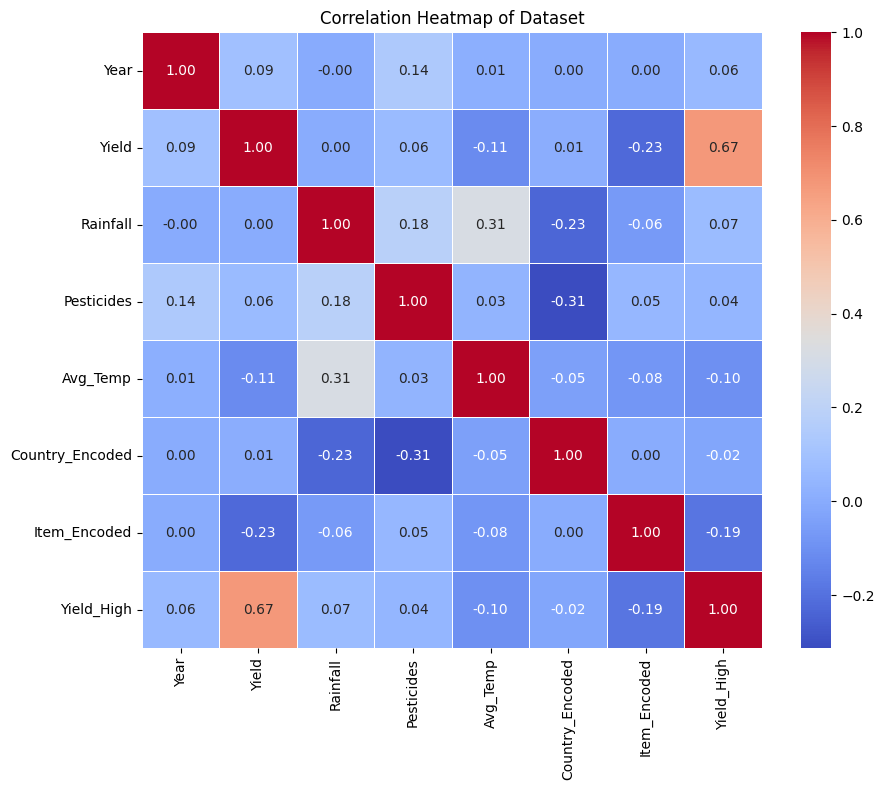

In [12]:
# Creating a correlation heatmap for the numerical columns in the dataset

# Calculate the correlation matrix
corr_matrix = data.corr(numeric_only=True)

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Dataset')
plt.show()


Yield threshold (median): 38295.0
Class distribution (0=low, 1=high):
Yield_High
1    0.500106
0    0.499894
Name: proportion, dtype: float64
Training LogisticRegression ...
=== LogisticRegression (Classification) ===
Accuracy : 0.6141
Precision: 0.6161
Recall   : 0.6057
F1-score : 0.6109
FNR      : 0.3943
FPR      : 0.3775
Confusion Matrix [TN FP; FN TP]:
[[1758 1066]
 [1114 1711]]

Training KNN ...
=== KNN (Classification) ===
Accuracy : 0.9644
Precision: 0.9659
Recall   : 0.9628
F1-score : 0.9644
FNR      : 0.0372
FPR      : 0.0340
Confusion Matrix [TN FP; FN TP]:
[[2728   96]
 [ 105 2720]]

Training LinearSVC ...


Liblinear failed to converge, increase the number of iterations.


=== LinearSVC (Classification) ===
Accuracy : 0.6132
Precision: 0.6157
Recall   : 0.6028
F1-score : 0.6092
FNR      : 0.3972
FPR      : 0.3764
Confusion Matrix [TN FP; FN TP]:
[[1761 1063]
 [1122 1703]]

Training SVC_RBF ...
=== SVC_RBF (Classification) ===
Accuracy : 0.7554
Precision: 0.7757
Recall   : 0.7186
F1-score : 0.7460
FNR      : 0.2814
FPR      : 0.2079
Confusion Matrix [TN FP; FN TP]:
[[2237  587]
 [ 795 2030]]

Training GaussianNB ...
=== GaussianNB (Classification) ===
Accuracy : 0.6091
Precision: 0.6464
Recall   : 0.4821
F1-score : 0.5523
FNR      : 0.5179
FPR      : 0.2638
Confusion Matrix [TN FP; FN TP]:
[[2079  745]
 [1463 1362]]

Training DecisionTree ...
=== DecisionTree (Classification) ===
Accuracy : 0.9701
Precision: 0.9689
Recall   : 0.9713
F1-score : 0.9701
FNR      : 0.0287
FPR      : 0.0312
Confusion Matrix [TN FP; FN TP]:
[[2736   88]
 [  81 2744]]

Training RandomForest ...
=== RandomForest (Classification) ===
Accuracy : 0.9745
Precision: 0.9752
Recall   : 

[I 2025-11-27 12:45:13,435] A new study created in memory with name: no-name-c613430d-ff6e-4017-b5e8-630d160cab20


=== XGBClassifier (Classification) ===
Accuracy : 0.9724
Precision: 0.9809
Recall   : 0.9635
F1-score : 0.9721
FNR      : 0.0365
FPR      : 0.0188
Confusion Matrix [TN FP; FN TP]:
[[2771   53]
 [ 103 2722]]

=== All model metrics (classification) ===
                    accuracy  precision    recall        f1       fnr  \
model                                                                   
RandomForest        0.974509   0.975186  0.973805  0.974495  0.026195   
ExtraTrees          0.973978   0.972477  0.975575  0.974024  0.024425   
XGBClassifier       0.972384   0.980901  0.963540  0.972143  0.036460   
DecisionTree        0.970083   0.968927  0.971327  0.970126  0.028673   
KNN                 0.964418   0.965909  0.962832  0.964368  0.037168   
GradientBoosting    0.918924   0.926794  0.909735  0.918185  0.090265   
SVC_RBF             0.755355   0.775697  0.718584  0.746049  0.281416   
LogisticRegression  0.614091   0.616133  0.605664  0.610853  0.394336   
LinearSVC          

[I 2025-11-27 12:45:14,873] Trial 0 finished with value: 0.9342179693526088 and parameters: {'n_estimators': 204, 'max_depth': 3, 'learning_rate': 0.17156921355077434, 'subsample': 0.8669789108328492, 'colsample_bytree': 0.6352919497668987, 'min_child_weight': 9.067254171362428, 'gamma': 3.869198609613856, 'reg_lambda': 0.8350345907402458, 'reg_alpha': 3.1848358540528423}. Best is trial 0 with value: 0.9342179693526088.
[I 2025-11-27 12:45:15,601] Trial 1 finished with value: 0.9397657593084064 and parameters: {'n_estimators': 110, 'max_depth': 3, 'learning_rate': 0.20166029040065592, 'subsample': 0.7006974102786382, 'colsample_bytree': 0.9212522960838411, 'min_child_weight': 3.3441450159563675, 'gamma': 4.114300454983969, 'reg_lambda': 0.029710765215530628, 'reg_alpha': 0.09784043394410313}. Best is trial 1 with value: 0.9397657593084064.
[I 2025-11-27 12:45:16,473] Trial 2 finished with value: 0.9409109747365814 and parameters: {'n_estimators': 649, 'max_depth': 9, 'learning_rate': 0


Best Optuna trial value (F1-score CV): 0.9709909567247107
Best Optuna params:
{'n_estimators': 457, 'max_depth': 10, 'learning_rate': 0.1670145579887896, 'subsample': 0.8248198605170374, 'colsample_bytree': 0.8110971569296199, 'min_child_weight': 7.789935581914764, 'gamma': 0.23476160739859253, 'reg_lambda': 0.0229416630595992, 'reg_alpha': 0.4186984757071224}
=== ProposedModel_XGB_Optuna (Classification) ===
Accuracy : 0.9750
Precision: 0.9749
Recall   : 0.9752
F1-score : 0.9750
FNR      : 0.0248
FPR      : 0.0251
Confusion Matrix [TN FP; FN TP]:
[[2753   71]
 [  70 2755]]

=== Proposed model metrics (XGB tuned with Optuna) ===
accuracy        0.975040
precision       0.974876
recall          0.975221
f1              0.975049
fnr             0.024779
fpr             0.025142
tn           2753.000000
fp             71.000000
fn             70.000000
tp           2755.000000
dtype: float64
=== XGBRegressor (based on tuned params) (Regression) ===
RMSE: 14713.4802
R^2 : 0.9702


Computi

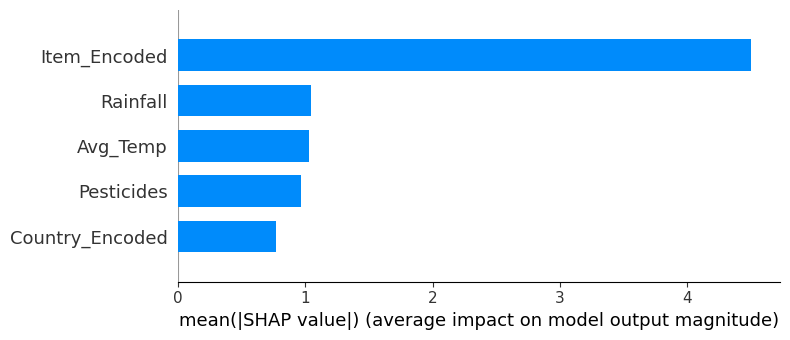

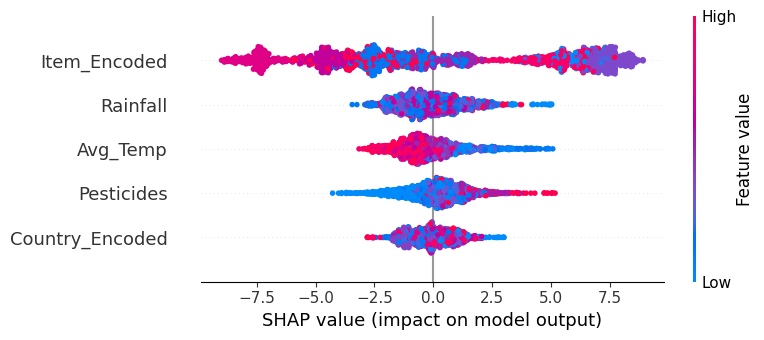

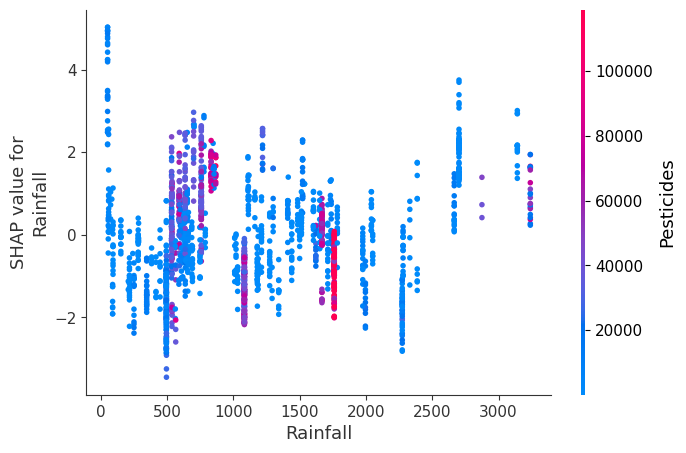

In [15]:
# ============================================
# 0. (Optional) Install libraries if needed
# ============================================
# On Kaggle you usually don't need these, but for local runs you might:
# !pip install optuna shap xgboost

# ============================================
# 1. Imports
# ============================================
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, mean_squared_error, r2_score
)

# Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier
)

# Regression model for optional continuous yield prediction
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBClassifier, XGBRegressor

import optuna
import shap
import matplotlib.pyplot as plt

# ============================================
# 2. Load and prepare data
# ============================================
data = pd.read_csv("/kaggle/input/crop-yield-prediction-dataset/yield_df.csv")

# Rename for convenience
data = data.rename(columns={
    "hg/ha_yield": "Yield",
    "average_rain_fall_mm_per_year": "Rainfall",
    "pesticides_tonnes": "Pesticides",
    "avg_temp": "Avg_Temp"
})

# Drop index-like column if present
if "Unnamed: 0" in data.columns:
    data = data.drop(columns=["Unnamed: 0"])

# Encode categorical variables
le_country = LabelEncoder()
le_item = LabelEncoder()

data["Country_Encoded"] = le_country.fit_transform(data["Area"])
data["Item_Encoded"] = le_item.fit_transform(data["Item"])

# Features
feature_cols = ["Country_Encoded", "Item_Encoded", "Pesticides", "Avg_Temp", "Rainfall"]
X = data[feature_cols]

# ============================================
# 3. Create CLASSIFICATION target (high vs low yield)
#    -> required for Accuracy, Precision, Recall, F1, FNR, FPR
# ============================================
# You can change this threshold if you want
yield_threshold = data["Yield"].median()
print("Yield threshold (median):", yield_threshold)

data["Yield_High"] = (data["Yield"] >= yield_threshold).astype(int)
y_cls = data["Yield_High"]

print("Class distribution (0=low, 1=high):")
print(y_cls.value_counts(normalize=True))

# Also keep regression target if you still care about continuous yield
y_reg = data["Yield"]

# ============================================
# 4. Train/test split
# ============================================
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)

# ============================================
# 5. Metric functions
# ============================================
def evaluate_classification(y_true, y_pred, model_name="Model"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0.0  # False Negative Rate
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0  # False Positive Rate

    print(f"=== {model_name} (Classification) ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"FNR      : {fnr:.4f}")
    print(f"FPR      : {fpr:.4f}")
    print("Confusion Matrix [TN FP; FN TP]:")
    print(np.array([[tn, fp], [fn, tp]]))
    print()

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "fnr": fnr,
        "fpr": fpr,
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "tp": tp
    }

def evaluate_regression(y_true, y_pred, model_name="Model"):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"=== {model_name} (Regression) ===")
    print(f"RMSE: {rmse:.4f}")
    print(f"R^2 : {r2:.4f}")
    print()
    return rmse, r2

# ============================================
# 6. Define at least 10 classification models
# ============================================
models = {
    # 1 - Logistic Regression
    "LogisticRegression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000, random_state=42))
    ]),

    # 2 - KNN
    "KNN": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", KNeighborsClassifier(n_neighbors=7))
    ]),

    # 3 - Linear SVM
    "LinearSVC": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LinearSVC(random_state=42))
    ]),

    # 4 - RBF SVM
    "SVC_RBF": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel="rbf", probability=True, random_state=42))
    ]),

    # 5 - Gaussian Naive Bayes
    "GaussianNB": GaussianNB(),

    # 6 - Decision Tree
    "DecisionTree": DecisionTreeClassifier(
        max_depth=None,
        min_samples_split=2,
        random_state=42
    ),

    # 7 - Random Forest
    "RandomForest": RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    ),

    # 8 - Extra Trees
    "ExtraTrees": ExtraTreesClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    ),

    # 9 - Gradient Boosting
    "GradientBoosting": GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.05,
        random_state=42
    ),

    # 10 - XGBoost (baseline)
    "XGBClassifier": XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42,
        n_jobs=-1
    )
}

# ============================================
# 7. Run ALL 10 models and collect ALL metrics
# ============================================
results = []

for name, model in models.items():
    print(f"Training {name} ...")
    model.fit(X_train_cls, y_train_cls)
    y_pred = model.predict(X_test_cls)
    metrics = evaluate_classification(y_test_cls, y_pred, name)
    metrics["model"] = name
    results.append(metrics)

results_df = pd.DataFrame(results).set_index("model")
print("=== All model metrics (classification) ===")
print(results_df.sort_values("f1", ascending=False))

# This table is your main comparison:
# columns: accuracy, precision, recall, f1, fnr, fpr, tn, fp, fn, tp

# ============================================
# 8. Pick best baseline model by F1-score
# ============================================
best_baseline_name = results_df["f1"].idxmax()
print("\nBest baseline model by F1-score:", best_baseline_name)
best_baseline_metrics = results_df.loc[best_baseline_name]
print(best_baseline_metrics)

# ============================================
# 9. PROPOSED MODEL: XGBClassifier tuned with Optuna
#    (Advanced model with hyperparameter optimization)
# ============================================

def objective_xgb_cls(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 700),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 10.0),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "use_label_encoder": False,
        "n_jobs": -1,
        "random_state": 42
    }

    model = XGBClassifier(**params)
    # 3-fold CV on training set, optimize F1-score
    scores = cross_val_score(
        model,
        X_train_cls,
        y_train_cls,
        cv=3,
        scoring="f1",
        n_jobs=-1
    )
    return scores.mean()

print("\nRunning Optuna tuning for XGBClassifier (this may take some time)...")
study_xgb_cls = optuna.create_study(direction="maximize")
study_xgb_cls.optimize(objective_xgb_cls, n_trials=30, show_progress_bar=False)

print("\nBest Optuna trial value (F1-score CV):", study_xgb_cls.best_trial.value)
print("Best Optuna params:")
print(study_xgb_cls.best_trial.params)

best_params_xgb_cls = study_xgb_cls.best_trial.params
best_params_xgb_cls.update({
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "use_label_encoder": False,
    "n_jobs": -1,
    "random_state": 42
})

proposed_model = XGBClassifier(**best_params_xgb_cls)
proposed_model.fit(X_train_cls, y_train_cls)

y_pred_proposed = proposed_model.predict(X_test_cls)
proposed_metrics = evaluate_classification(
    y_test_cls, y_pred_proposed, "ProposedModel_XGB_Optuna"
)

print("=== Proposed model metrics (XGB tuned with Optuna) ===")
print(pd.Series(proposed_metrics))

# ============================================
# 10. (Optional) Regression performance for yield
#      with XGBRegressor (using similar params)
# ============================================
best_params_xgb_reg = study_xgb_cls.best_trial.params.copy()
best_params_xgb_reg.update({
    "objective": "reg:squarederror",
    "n_jobs": -1,
    "random_state": 42
})

xgb_reg = XGBRegressor(**best_params_xgb_reg)
xgb_reg.fit(X_train_reg, y_train_reg)
y_pred_reg = xgb_reg.predict(X_test_reg)
evaluate_regression(y_test_reg, y_pred_reg, "XGBRegressor (based on tuned params)")

# ============================================
# 11. XAI: SHAP for the PROPOSED model
# ============================================
print("\nComputing SHAP values for proposed XGB model (classification)...")
# Sample to speed up SHAP if dataset is large
X_sample = X_train_cls.sample(n=min(2000, len(X_train_cls)), random_state=42)

explainer = shap.TreeExplainer(proposed_model)
shap_values = explainer.shap_values(X_sample)

# For some versions, shap_values is list; for others it's array
if isinstance(shap_values, list):
    shap_values_to_use = shap_values[1]  # class 1 (high yield)
else:
    shap_values_to_use = shap_values

shap.initjs()

# Global importance (bar)
shap.summary_plot(shap_values_to_use, X_sample, feature_names=feature_cols, plot_type="bar")

# Beewswarm summary
shap.summary_plot(shap_values_to_use, X_sample, feature_names=feature_cols)

# Example dependence plot: how Rainfall affects prediction
shap.dependence_plot("Rainfall", shap_values_to_use, X_sample, feature_names=feature_cols)


# XGB Tuned with Optuna — Best Performance

## 📊 Proposed Model Metrics

| Metric      | Value      |
|-------------|------------|
| **Accuracy** | 0.975040 |
| **Precision** | 0.974876 |
| **Recall** | 0.975221 |
| **F1-score** | 0.975049 |
| **FNR** | 0.024779 |
| **FPR** | 0.025142 |

## 🔢 Confusion Matrix Values

| Metric | Count |
|--------|--------|
| **TN** | 2753 |
| **FP** | 71 |
| **FN** | 70 |
| **TP** | 2755 |

